In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import mediapy
import cv2
sys.path.append('../package/mujoco_helper/') # for 'mujoco_parser'
sys.path.append('../package/kinematics_helper/') # for 'transforms'
sys.path.append('../package/utility/') # for 'utils'
from mujoco_parser import *
from transforms import *
from utils import *
from ik import *
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:",MUJOCO_VERSION)

MuJoCo version: (3, 1, 6)


In [2]:
xml_path = '../asset/scene_car.xml'
env = MuJoCoParserClass(name='Car Scene',rel_xml_path=xml_path,verbose=False)

colors = plt.get_cmap('tab20').colors + plt.get_cmap('tab20b').colors[:env.model.ngeom]
for i in range(env.model.ngeom):
    geom_name = mujoco.mj_id2name(env.model, mujoco.mjtObj.mjOBJ_GEOM, i)
    if geom_name != 'floor': env.model.geom_rgba[i][:3] = colors[i]
    # if geom_name != 'floor': env.model.geom_rgba[i][:3] = [0.3,0.3,0.3]

## Feature Detection

2024-11-28 12:40:51.850 python[9673:942835] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-28 12:40:51.850 python[9673:942835] +[IMKInputSession subclass]: chose IMKInputSession_Modern



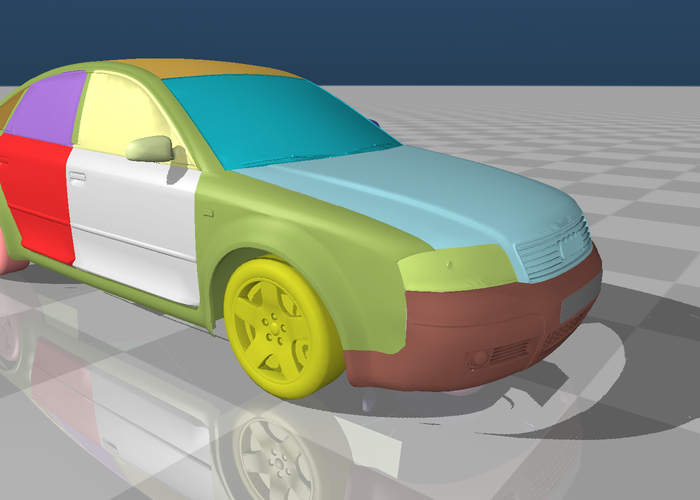

In [3]:
env.reset()
env.init_viewer(
    azimuth           = -135,
    distance          = 2.1,
    elevation         = -16,
    lookat            = [0.01, 0.11, 0.5],
    transparent       = False,
    black_sky         = False,
)

while env.is_viewer_alive():
    env.step()
    env.render()

    image1_backup, _ = env.grab_rgbd_img()
    if image1_backup.sum() > 0: image1 = image1_backup.copy()

env.close_viewer()

mediapy.show_image(image1, width=700)


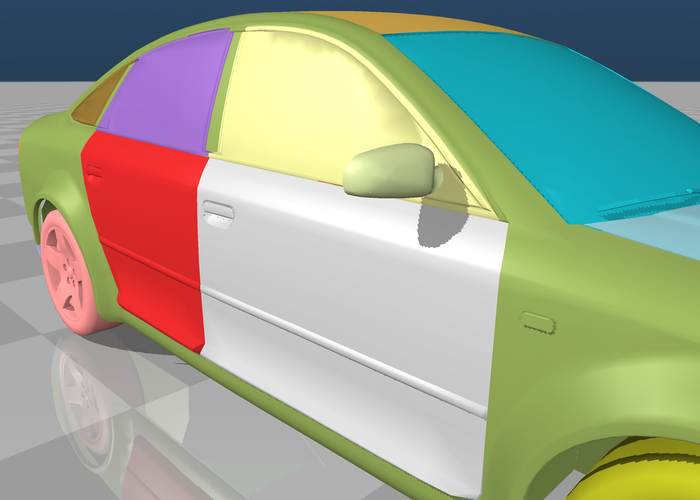

In [13]:
env.reset()
env.init_viewer(
    azimuth           = -135,
    distance          = 2.1,
    elevation         = -16,
    lookat            = [0.46, -0.34,  0.67],
    transparent       = False,
    black_sky         = False,
)

while env.is_viewer_alive():
    env.step()
    env.render()

    image2_backup, _ = env.grab_rgbd_img()
    if image2_backup.sum() > 0: image2 = image2_backup.copy()

env.close_viewer()

mediapy.show_image(image2, width=700)

### SIFT


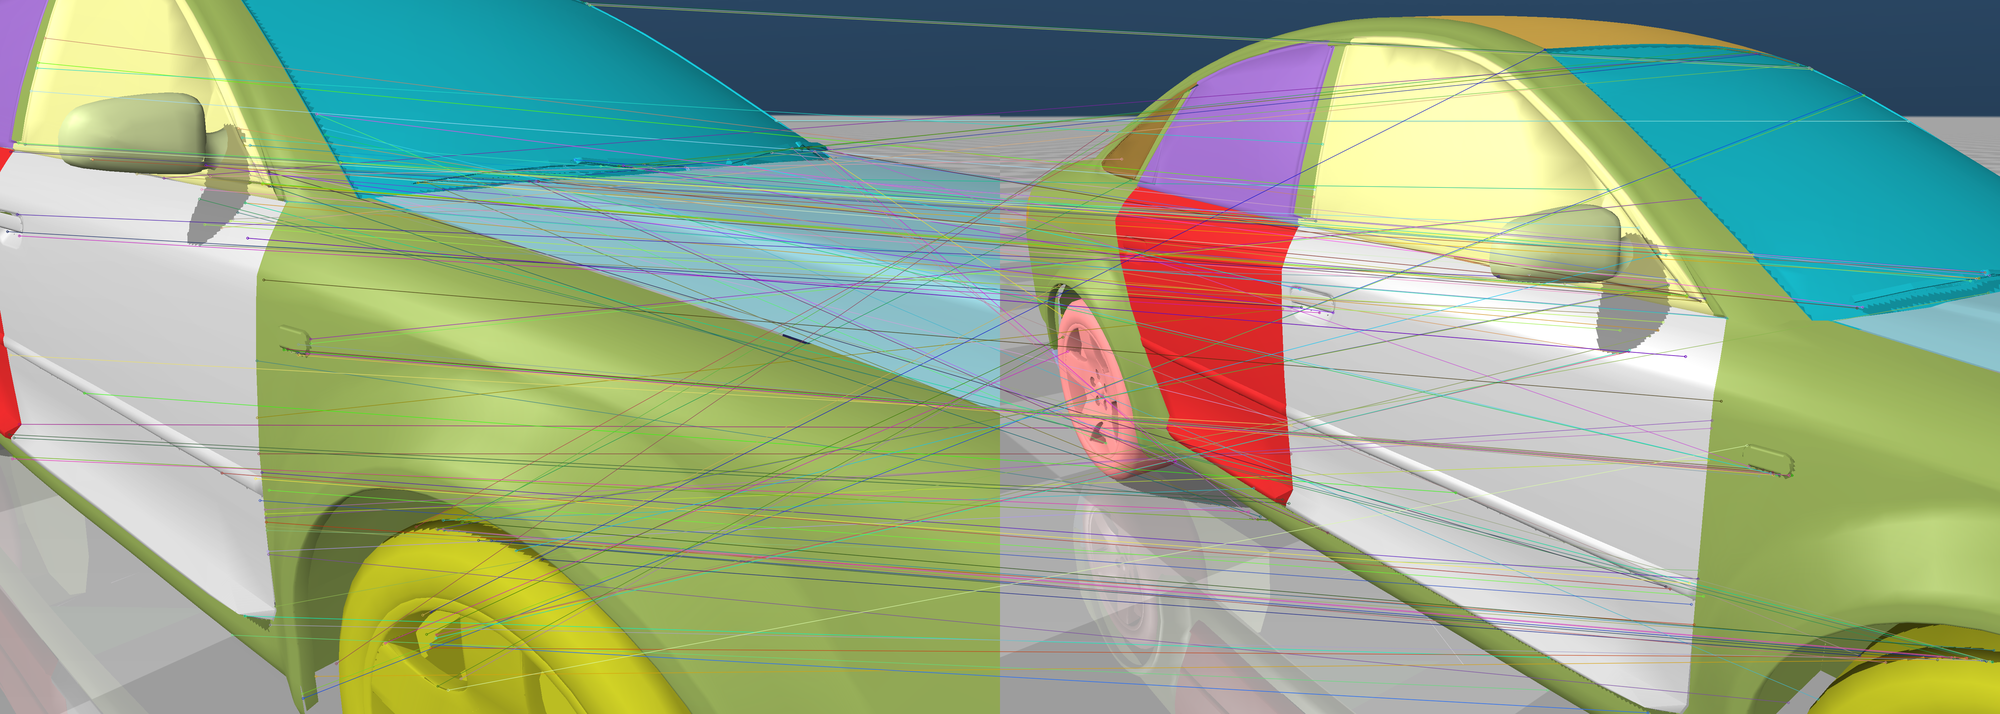

In [14]:
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

detector = cv2.xfeatures2d.SIFT_create()

kp1, desc1 = detector.detectAndCompute(image1, None)
kp2, desc2 = detector.detectAndCompute(image2, None)

matcher = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = matcher.match(desc1, desc2)
matches = sorted(matches, key=lambda x: x.distance)
min_dist, max_dist = matches[-1].distance, matches[0].distance

ratio = 0.00001
boundary = (max_dist - min_dist) * ratio + min_dist
correct_matches = [m for m in matches if m.distance < boundary]

res = cv2.drawMatches(image1, kp1, image2, kp2, correct_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

mediapy.show_image(res, width = 2000)

### FAST + BRIEF


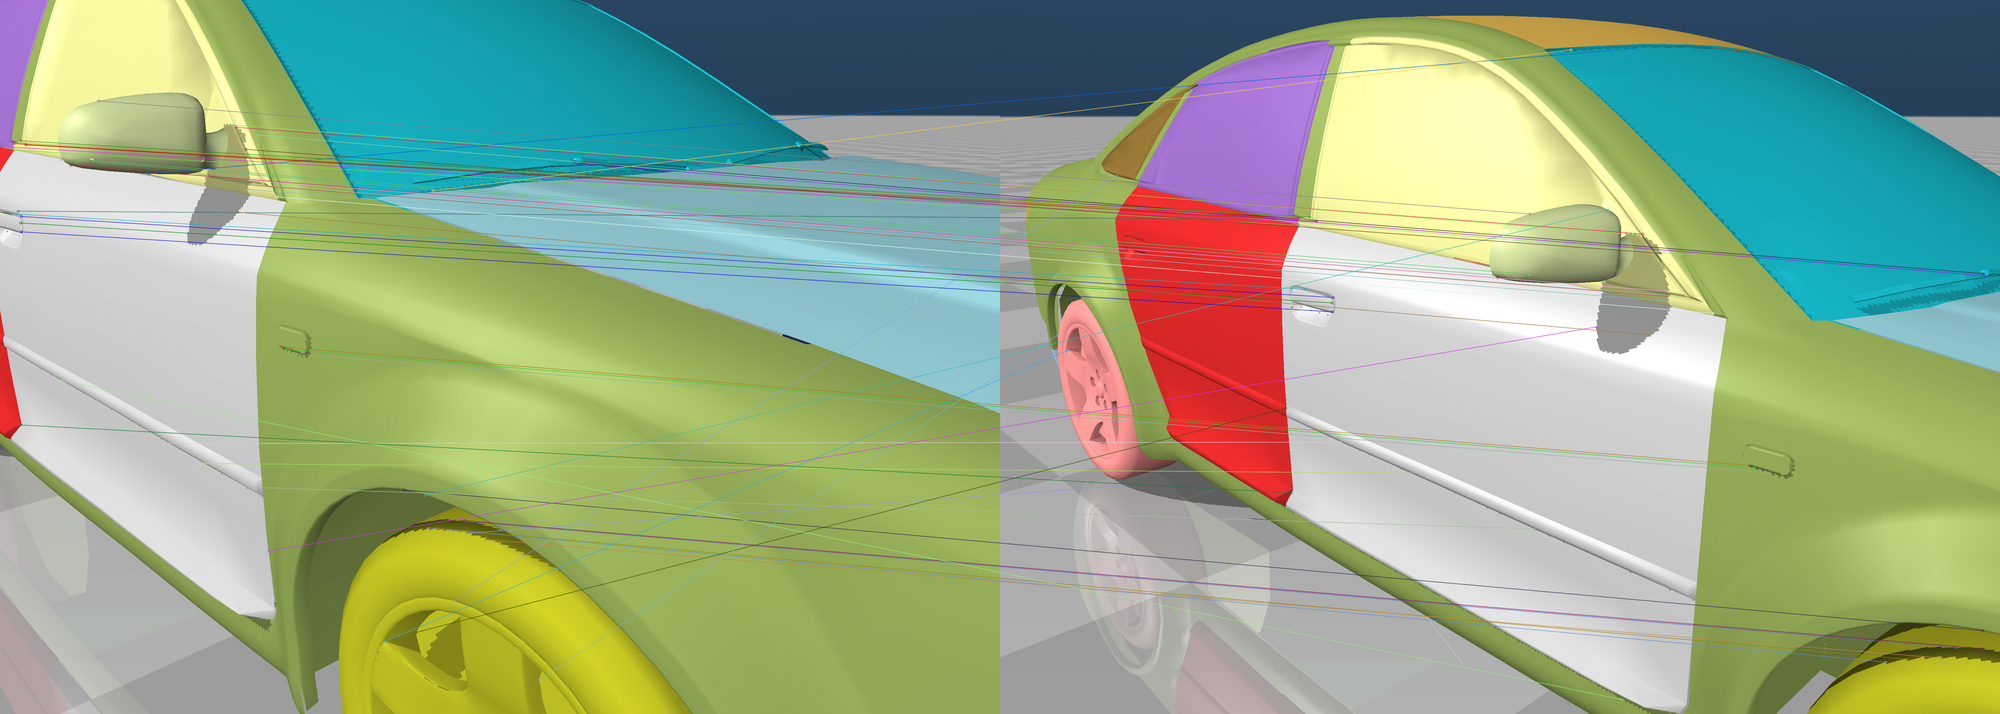

In [15]:
class FASTBRIEFDetector:
    def __init__(self, threshold=30, n_fast=500):
        """
        Initialize FAST and BRIEF detector
        
        Parameters:
        threshold: FAST detection threshold (default: 30)
        n_fast: Number of maximum features to retain (default: 500)
        """
        # Initialize FAST detector
        self.fast = cv2.FastFeatureDetector_create(
            threshold=threshold,  # Detection threshold value
            nonmaxSuppression=True  # Apply non-max suppression
        )
        self.n_fast = n_fast
        
        # Initialize BRIEF descriptor
        self.brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
    
    def detectAndCompute(self, image, mask=None):
        """
        Detect keypoints using FAST and compute BRIEF descriptors
        
        Parameters:
        image: Input image
        mask: Optional mask
        
        Returns:
        keypoints: Detected keypoints
        descriptors: Computed descriptors
        """
        # Convert image to grayscale if needed
        if len(image.shape) > 2:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()
            
        # Detect keypoints using FAST
        keypoints = self.fast.detect(gray, mask)
        
        # Sort keypoints by response strength
        keypoints = sorted(keypoints, key=lambda x: x.response, reverse=True)
        
        # Keep only the strongest n_fast keypoints
        keypoints = keypoints[:self.n_fast]
        
        # Compute BRIEF descriptors
        keypoints, descriptors = self.brief.compute(gray, keypoints)
        
        return keypoints, descriptors

def match_features(img1, img2):
    """
    Match features between two images using FAST and BRIEF
    
    Parameters:
    img1, img2: Input images
    
    Returns:
    matches: List of matches
    img_matches: Image showing the matches
    """
    # Initialize detector
    detector = FASTBRIEFDetector()
    
    # Detect and compute
    kp1, des1 = detector.detectAndCompute(img1)
    kp2, des2 = detector.detectAndCompute(img2)
    
    # Initialize BFMatcher with Hamming distance
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    # Match descriptors
    matches = bf.match(des1, des2)
    
    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)
    
    # Draw matches
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None,
                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    return matches, img_matches, kp1, kp2


# Basic matching
matches, result, kp1, kp2 = match_features(image1, image2)
mediapy.show_image(result, width=2000)

### ORB


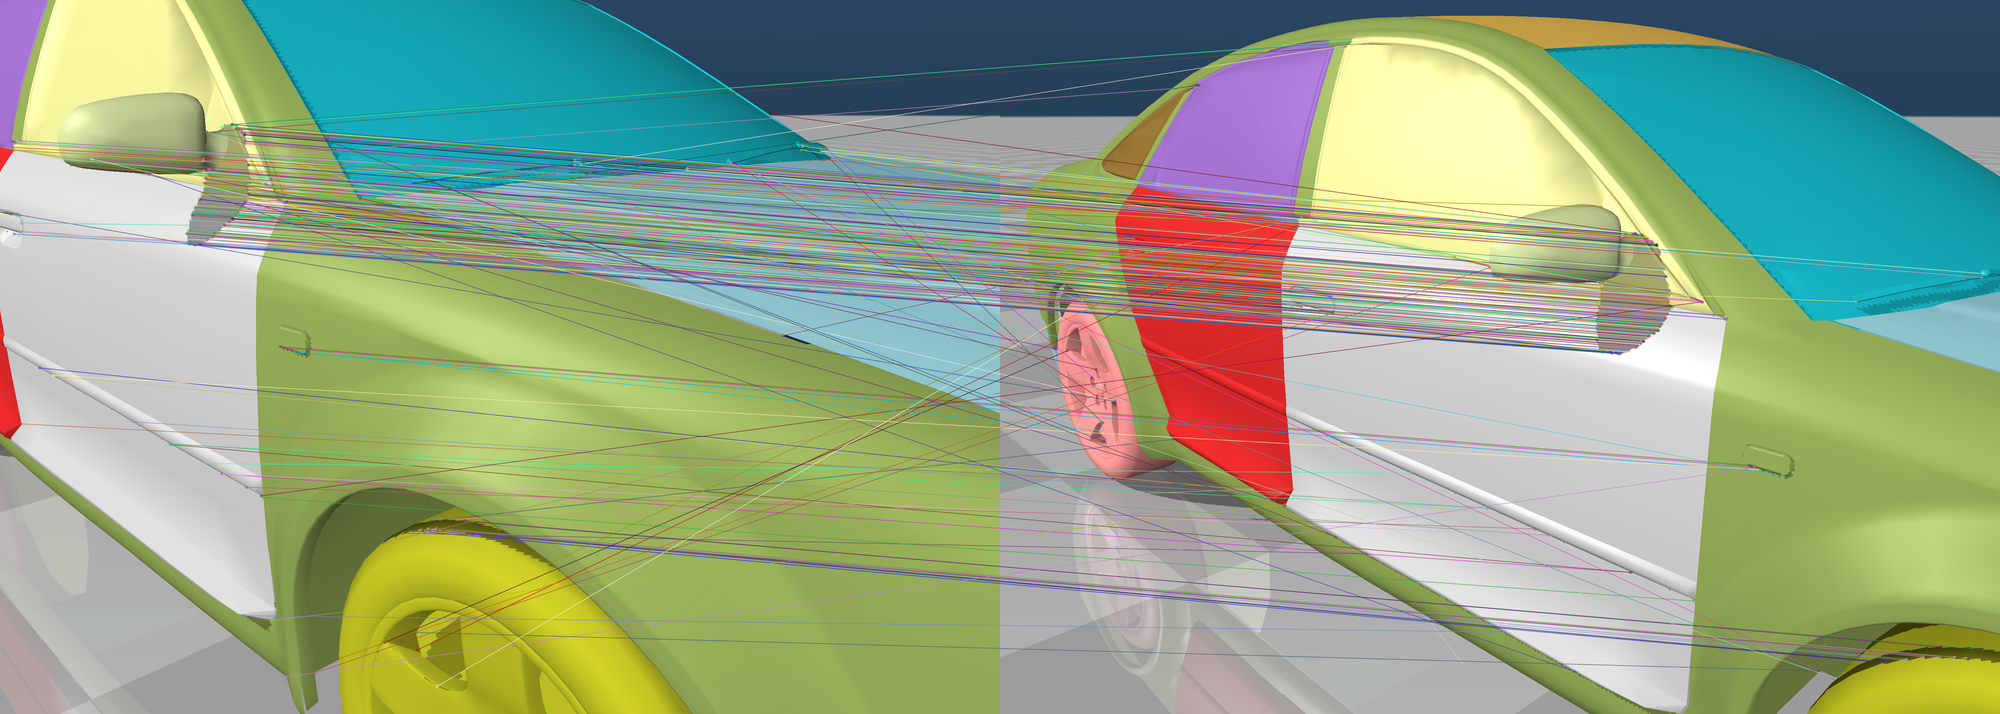

In [16]:
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

detector = cv2.ORB_create(nfeatures=1000)

kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)

matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = matcher.match(desc1, desc2)
matches = sorted(matches, key=lambda x: x.distance)
min_dist, max_dist = matches[-1].distance, matches[0].distance

ratio = 0.001 
boundary = (max_dist - min_dist) * ratio + min_dist
correct_matches = [m for m in matches if m.distance < boundary]

res = cv2.drawMatches(image1, kp1, image2, kp2, correct_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

mediapy.show_image(res, width=2000)

### BRISK


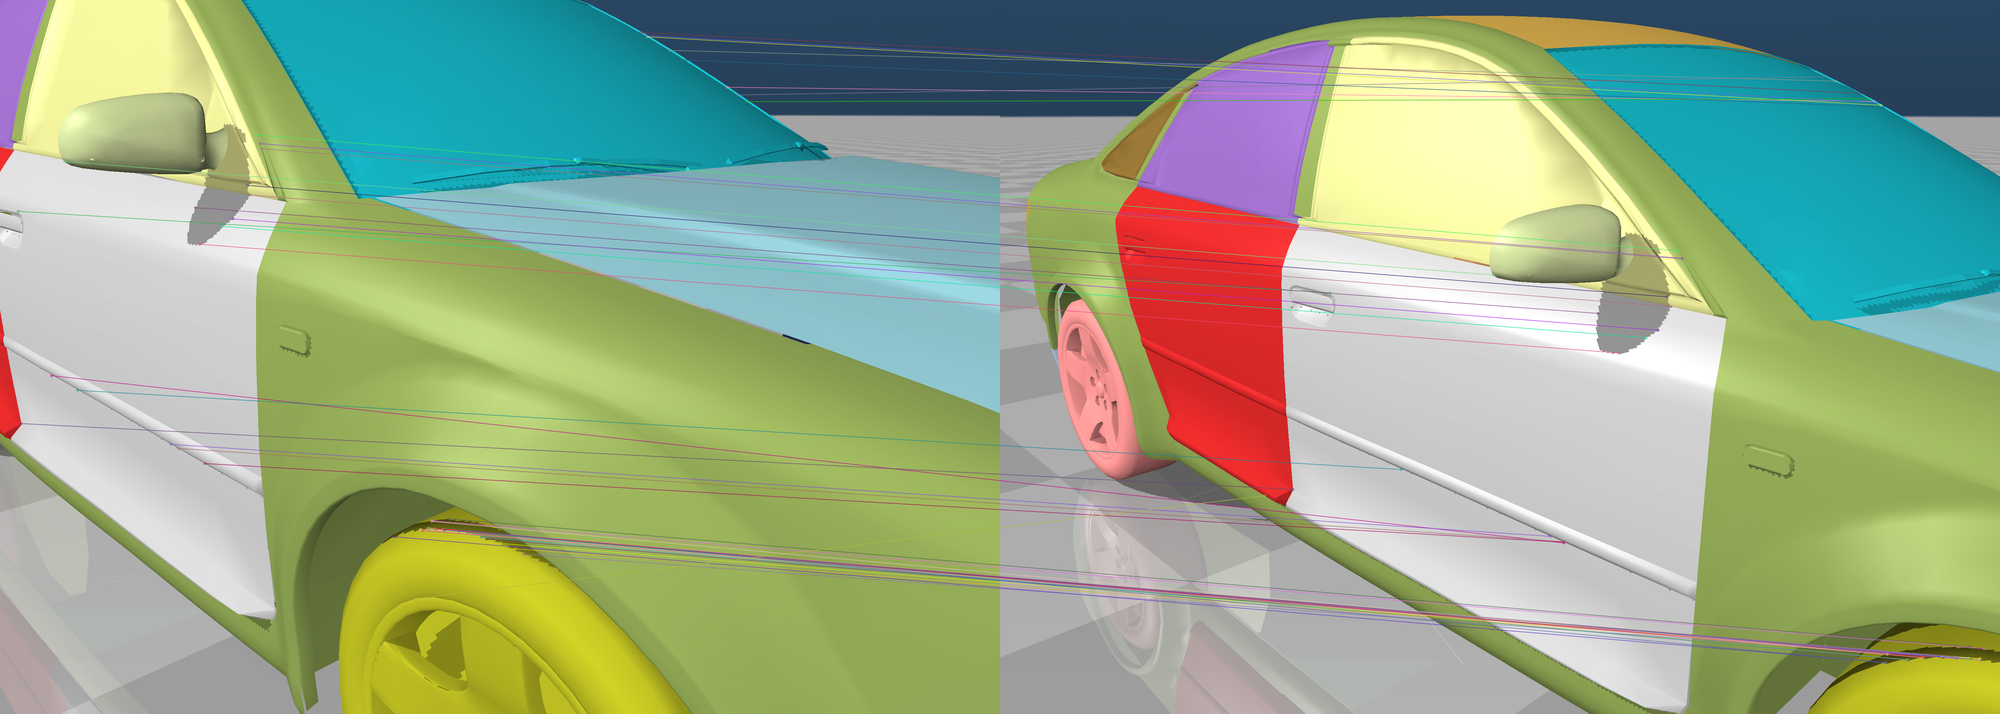

Match statistics:
Number of matches: 356
Average distance: 69.24
Keypoints ratio: 0.68


In [17]:
class BRISKDetector:
    def __init__(self, threshold=30, octaves=3, pattern_scale=1.0):
        """
        Initialize BRISK detector
        
        Parameters:
        threshold: BRISK detection threshold (default: 30)
        octaves: Number of octaves in the detection pyramid (default: 3)
        pattern_scale: Scale of the sampling pattern (default: 1.0)
        """
        # Initialize BRISK detector
        self.brisk = cv2.BRISK_create(
            thresh=threshold,  # Detection threshold
            octaves=octaves,  # Detection octaves (pyramid levels)
            patternScale=pattern_scale  # Scale of the sampling pattern
        )
    
    def detectAndCompute(self, image, mask=None):
        """
        Detect keypoints and compute descriptors using BRISK
        
        Parameters:
        image: Input image
        mask: Optional mask
        
        Returns:
        keypoints: Detected keypoints
        descriptors: Computed descriptors
        """
        # Convert image to grayscale if needed
        if len(image.shape) > 2:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()
        
        # Detect keypoints and compute descriptors
        keypoints, descriptors = self.brisk.detectAndCompute(gray, mask)
        
        return keypoints, descriptors

def match_features(img1, img2, max_matches=50):
    """
    Match features between two images using BRISK
    
    Parameters:
    img1, img2: Input images
    max_matches: Maximum number of matches to draw (default: 50)
    
    Returns:
    matches: List of matches
    img_matches: Image showing the matches
    kp1, kp2: Keypoints from both images
    """
    # Initialize detector
    detector = BRISKDetector()
    
    # Detect and compute
    kp1, des1 = detector.detectAndCompute(img1)
    kp2, des2 = detector.detectAndCompute(img2)
    
    if des1 is None or des2 is None or len(kp1) < 2 or len(kp2) < 2:
        print("Not enough keypoints found in one or both images")
        return [], None, kp1, kp2
    
    # Initialize BFMatcher with Hamming distance
    # (BRISK uses binary descriptors)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    # Match descriptors
    matches = bf.match(des1, des2)
    
    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)
    
    # Draw matches
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:max_matches], None,
                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    return matches, img_matches, kp1, kp2

def analyze_matches(matches, kp1, kp2):
    """
    Analyze the quality of matches
    
    Parameters:
    matches: List of matches
    kp1, kp2: Keypoints from both images
    
    Returns:
    dict: Dictionary containing match statistics
    """
    if not matches:
        return {
            "num_matches": 0,
            "avg_distance": 0,
            "min_distance": 0,
            "max_distance": 0,
            "keypoints_ratio": 0
        }
    
    distances = [m.distance for m in matches]
    
    return {
        "num_matches": len(matches),
        "avg_distance": np.mean(distances),
        "min_distance": np.min(distances),
        "max_distance": np.max(distances),
        "keypoints_ratio": min(len(kp1), len(kp2)) / max(len(kp1), len(kp2))
    }

matches, result, kp1, kp2 = match_features(image1, image2)
if result is not None:
    mediapy.show_image(result, width=2000)
    
    # Analyze matches
    stats = analyze_matches(matches, kp1, kp2)
    print("Match statistics:")
    print(f"Number of matches: {stats['num_matches']}")
    print(f"Average distance: {stats['avg_distance']:.2f}")
    print(f"Keypoints ratio: {stats['keypoints_ratio']:.2f}")

### AKAZE


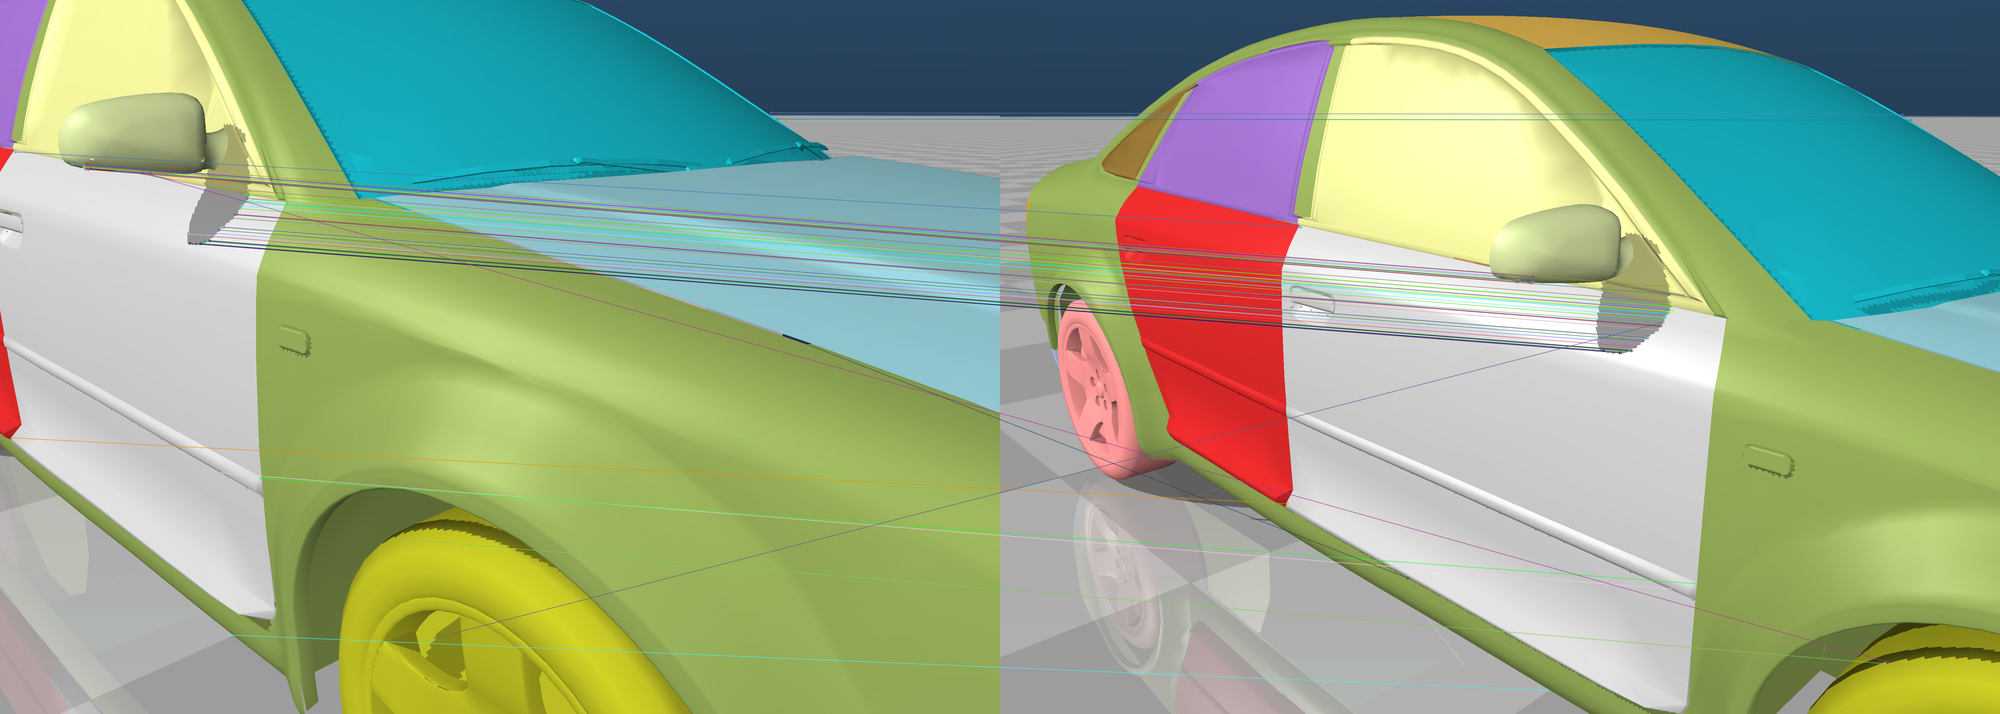


Match Statistics:
Keypoints in image 1: 627
Keypoints in image 2: 972
Number of matches: 239
Average distance: 70.84
Distance std dev: 24.71
Keypoints ratio: 0.65


In [18]:
class AKAZEDetector:
    def __init__(self, 
                 descriptor_type=cv2.AKAZE_DESCRIPTOR_MLDB,
                 descriptor_size=0,  # 0 for full size
                 descriptor_channels=3,
                 threshold=0.001,
                 n_octaves=4,
                 n_octave_layers=4):
        """
        Initialize AKAZE detector
        
        Parameters:
        descriptor_type: Type of the descriptor (default: MLDB)
        descriptor_size: Size of the descriptor (0=full, 1=upright)
        descriptor_channels: Number of channels in the descriptor (3)
        threshold: Detector threshold (default: 0.001)
        n_octaves: Maximum octave evolution (default: 4)
        n_octave_layers: Default number of sublevels per scale level (default: 4)
        """
        self.akaze = cv2.AKAZE_create(
            descriptor_type=descriptor_type,
            descriptor_size=descriptor_size,
            descriptor_channels=descriptor_channels,
            threshold=threshold,
            nOctaves=n_octaves,
            nOctaveLayers=n_octave_layers
        )
    
    def detectAndCompute(self, image, mask=None):
        """
        Detect keypoints and compute descriptors using AKAZE
        
        Parameters:
        image: Input image
        mask: Optional mask
        
        Returns:
        keypoints: Detected keypoints
        descriptors: Computed descriptors
        """
        # Convert image to grayscale if needed
        if len(image.shape) > 2:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()
        
        # Detect keypoints and compute descriptors
        keypoints, descriptors = self.akaze.detectAndCompute(gray, mask)
        
        return keypoints, descriptors

def match_features(img1, img2, max_matches=50):
    """
    Match features between two images using AKAZE
    
    Parameters:
    img1, img2: Input images
    max_matches: Maximum number of matches to draw (default: 50)
    
    Returns:
    matches: List of matches
    img_matches: Image showing the matches
    kp1, kp2: Keypoints from both images
    """
    # Initialize detector
    detector = AKAZEDetector()
    
    # Detect and compute
    kp1, des1 = detector.detectAndCompute(img1)
    kp2, des2 = detector.detectAndCompute(img2)
    
    if des1 is None or des2 is None or len(kp1) < 2 or len(kp2) < 2:
        print("Not enough keypoints found in one or both images")
        return [], None, kp1, kp2
    
    # Initialize BFMatcher with Hamming distance
    # (AKAZE uses binary descriptors)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    # Match descriptors
    matches = bf.match(des1, des2)
    
    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)
    
    # Draw matches
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:max_matches], None,
                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    return matches, img_matches, kp1, kp2

def analyze_matches(matches, kp1, kp2, print_stats=True):
    """
    Analyze the quality of matches
    
    Parameters:
    matches: List of matches
    kp1, kp2: Keypoints from both images
    print_stats: Whether to print statistics (default: True)
    
    Returns:
    dict: Dictionary containing match statistics
    """
    stats = {
        "num_keypoints_1": len(kp1),
        "num_keypoints_2": len(kp2),
        "num_matches": len(matches) if matches else 0,
    }
    
    if matches:
        distances = [m.distance for m in matches]
        stats.update({
            "avg_distance": np.mean(distances),
            "min_distance": np.min(distances),
            "max_distance": np.max(distances),
            "std_distance": np.std(distances),
            "keypoints_ratio": min(len(kp1), len(kp2)) / max(len(kp1), len(kp2))
        })
    
    if print_stats:
        print("\nMatch Statistics:")
        print(f"Keypoints in image 1: {stats['num_keypoints_1']}")
        print(f"Keypoints in image 2: {stats['num_keypoints_2']}")
        print(f"Number of matches: {stats['num_matches']}")
        if matches:
            print(f"Average distance: {stats['avg_distance']:.2f}")
            print(f"Distance std dev: {stats['std_distance']:.2f}")
            print(f"Keypoints ratio: {stats['keypoints_ratio']:.2f}")
    
    return stats

matches, result, kp1, kp2 = match_features(image1, image2)
if result is not None:
    mediapy.show_image(result, width=2000)
    stats = analyze_matches(matches, kp1, kp2)